# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values = "-999").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Drop variables that have > 40% of the observations missing
dat = dat.dropna(thresh = len(dat)*0.6, axis = 1)

# Print final df shape
print(f"Final DataFrame shape: {dat.shape}")

dat.head()

Final DataFrame shape: (214, 17)


,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,1.00,0,1,1,0,1
1,1082.0,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,0,1
2,946.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,NaN,1,0,0,0,0
3,1180.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,1.01,1,1,1,0,1
4,1212.5,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,1,1


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
print(f"NAs before imputing:\n\n{dat.isna().sum()}")

NAs before imputing:

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64


In [4]:
# Separate numeric and categorical columns
numeric_cols = dat.select_dtypes(include=['number']).columns
categorical_cols = dat.select_dtypes(include=['object']).columns

# Create imputers for numeric and categorical columns
numeric_imputer = KNNImputer(n_neighbors = 5)
categorical_imputer = SimpleImputer(strategy='most_frequent') 

# Impute missing values
dat[numeric_cols] = pd.DataFrame(numeric_imputer.fit_transform(dat[numeric_cols]))
dat[categorical_cols] = pd.DataFrame(categorical_imputer.fit_transform(dat[categorical_cols]))

# Check to ensure no more NA values
print(f"NAs after imputing:\n\n{dat.isna().sum()}")

NAs after imputing:

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [5]:
# Create new col `nClimates` that combines the info of the 5 climate type variables
dat['nClimates'] = dat['Dry'] + dat['Humid'] + dat['Montane'] + dat['Subarid'] + dat['Subhumid']

# Drop the original cols
df = dat.drop(['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'], axis = 1)

# Loop through categorical columns and encode 
for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    
df.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,78.0,1,0,1,1,0,1,0,1.0,2.0,3.0,1.000,3.0
1,1082.0,0,0,1,0,0,1,0,1.0,1.0,3.0,1.402,2.0
2,946.0,0,0,1,0,0,1,0,2.0,1.0,3.0,4.692,1.0
3,1180.0,0,0,1,0,0,1,0,2.0,1.0,3.0,1.010,4.0
4,1212.5,0,0,1,0,0,1,0,1.0,1.0,3.0,1.540,3.0


In [6]:
# Split into training and test sets ----
# Define features
X = df.drop('nClimates', axis = 1)

# Define targets
y = df['nClimates']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [7]:
# Train a single decision tree
dt = DecisionTreeRegressor(max_depth = 5, random_state = 808)
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)

# Visualize decision tree ----
plt.figure(figsize = (12, 15), dpi = 700)
plot_tree(dt, feature_names = X.columns, filled = True, fontsize = 6)
plt.title('Decision Tree with mex depth of 5')
plt.show()

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"DT Regressor MSE: {mse:.3f}")

DT Regressor MSE: 2.060


Based on the way this tree looks, what would you guess the most important variable to be?

Looking at the tree, I would guess that the most important feature is the first that the tree splits on, becuase it had the best predicitons from the start, performing better than any other feature for that first split. In this case, that variable is diet_plants. 

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [8]:
# Construct parameter grid
param_grid = {
    "max_features":["sqrt", 6, None],
    "n_estimators":[50, 100, 200],
    "max_depth":[3,4,5,6,7],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[1,2,4]
}


# Initialize Random forest regressor
rf = RandomForestRegressor(random_state = 808)

# Use cross-validation to find best combo of parameter values
gs = GridSearchCV(rf, param_grid = param_grid, n_jobs = -1, return_train_score = True, scoring = "neg_mean_squared_error")
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=808), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [9]:
# Print best combo of parameters
print(f"GS Best Parameters: {gs.best_params_}")

GS Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [10]:
# Train the best estimator
best_rf = RandomForestRegressor(**gs.best_params_, random_state = 808)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [11]:
# Generate predictions from best rf
y_pred_best = best_rf.predict(X_test)

# Print best params and MSE
print(f"Best Parameters: {gs.best_params_}")
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"\nRF Regressor MSE: {mse_best:.3f}")

# Extract feature importance from RF model
importance = best_rf.feature_importances_

# Create a list of feature names
feature_names = X_train.columns

# Create feature importance df
importance_df = (pd.DataFrame(zip(feature_names, importance), columns=['Feature', 'Importance'])
                 .sort_values(by = 'Importance', key = abs, ascending = False)
                 .reset_index(drop=True))

# Print the sorted feature importance
print("\nFeature Importances:\n", importance_df)

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

RF Regressor MSE: 1.436

Feature Importances:
                Feature  Importance
0        AdultBodyMass    0.258363
1           LitterSize    0.171953
2      ForagingStratum    0.140860
3          Diet_Plants    0.100498
4        ActivityCycle    0.080432
5       HabitatBreadth    0.065634
6   Diet_Invertebrates    0.038459
7          Diet_Fruits    0.033763
8           Diet_Seeds    0.031706
9         Diet_Flowers    0.030888
10    Diet_Vertebrates    0.025121
11          Diet_Other    0.022325


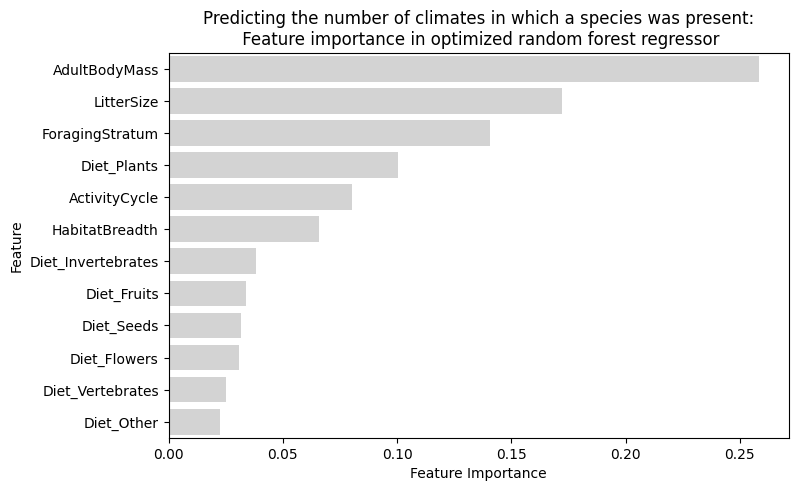

In [12]:
# Visualize feature importance ----

# Initalize figure
plt.figure(figsize=(8, 5))

# Plot feature importances
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], color = "lightgrey")

# Add axis labels
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

# Add title
plt.title("Predicting the number of climates in which a species was present:\n Feature importance in optimized random forest regressor")

# Show the plot
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

In [13]:
print(f"Single Tree MSE: {mse:.3f}")
print(f"Ensemble MSE: {mse_best:.3f}")



Single Tree MSE: 2.060
Ensemble MSE: 1.436


The ensemble model had better accuracy, as shown here by a lower MSE.

Adult body mass has the most influence on species' climate adaptability, followed by litter size. I find adult body mass to be a very interesting important feature in this case. It's known that mammmals tend to be smaller closer to the equator and larger near the poles, so I am curious how body mass is a predictor for their habitat versitility!